O3 농도 예측 모델의 학습 및 모델 예측 테스트 코드

VER: 
    
    v5.2.2

SETUP:

    In[NOx, VOC, 'VOC*NOx', 'NH3', 'PM25']
    Out[pred. O3]

STRUCTURE:

    CMAQ U-Net

    model = build_model(
        ..., 
        hidden_size=[96, 64],
        hidden_depth=5,
        ...,
        in_filters=10,
        ...
    )

PROPERTIES:

    1. 학습 시 모델의 입력 파라미터를 낮추어(입력 해상도를 낮춰) 모델의 출력 해상도에 스무딩을 적용하는 역할
    2. 모델의 깊이를 높여 입력 변수 간 비선형적 상호작용을 더 잘 반영할 수 있도록 구조화
        2-1.
            계층적 특징 추출:
                각 층은 이전 층의 출력을 비선형 활성화 함수를 통해 변환합니다. 여러 층을 쌓으면, 낮은 층에서는 간단한 패턴이나 국부적인 특징을 추출하고, 높은 층에서는 이들이 결합되어 보다 추상적이고 복잡한 패턴을 형성하게 됩니다. 이러한 계층적 구조는 입력 특성 간의 복잡한 상호작용과 비선형 관계를 효과적으로 모델링할 수 있도록 돕습니다.

            비선형 함수 근사 능력:
                심층 신경망은 이론적으로 임의의 복잡한 함수를 근사할 수 있는 보편 근사자(universal approximator)입니다. 층이 깊어질수록 여러 비선형 변환의 합성(composition)을 통해 더 복잡한 함수 형태를 학습할 수 있습니다. 따라서, hidden depth가 늘어나면 입력 특성의 복잡한 비선형 관계를 더 잘 반영할 수 있습니다.

            표현력 향상:
                각 추가 층은 모델에 추가적인 자유도를 부여하여, 데이터의 미묘한 패턴과 상호작용을 포착할 수 있게 합니다. 이는 특히, 입력 특성들 사이에 여러 단계의 상호작용이나 고차원적 비선형 관계가 존재하는 경우 유리합니다.

In [1]:
# Import
import os
import sys
sys.path.append('/home/user/workdir/CMAQ_Emulator/main')

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import r2_score

import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

2025-03-05 13:31:39.460372: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-05 13:31:39.492614: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-05 13:31:39.492644: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-05 13:31:39.492664: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-05 13:31:39.499004: I tensorflow/core/platform/cpu_feature_g

# Training

In [2]:
dataset_2013 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/dataset_for_o3_v5.1.csv')

ctrl_data = pd.concat([dataset_2013], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data = ctrl_data[:, :17*5]
label_path_2013 = '/home/user/workdir/CMAQ_Emulator/main/datasets/concentration/2013'
label_path = []
for i in range(1, 120): 
    label_path.append(os.path.join(label_path_2013, '1.00', f'ACONC.{i}'))
label_data = []
for path in label_path:
    with nc.Dataset(path) as f:
        label_data.append(f.variables['O3'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
label_data = np.array(label_data).reshape(len(label_data), 82, 67, 1)

In [ ]:
from src.model.cmaqnet_unet import build_model
from tensorflow.keras.callbacks import EarlyStopping

model_path = '/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.3(hidden)/final_model(adjustedv2)'  # 모델 저장 경로

epochs = 1000  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.4  # 테스트 데이터 비율 (50%)
random_seed = 42  # 랜덤 시드

X_emis_train, X_emis_test, y_train, y_test = train_test_split(emis_data, label_data, test_size=test_split, random_state=random_seed)

# Cosine Decay 스케줄 설정
steps_per_epoch = len(X_emis_train) // batch_size  # 정수 나눗셈
total_steps = epochs * steps_per_epoch

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-3,
        decay_steps=total_steps,
        alpha=0.1  # 최종 lr 비율 (0이면 최솟값이 0)
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    '''adjusted
    model = build_model(
        ctrl_dim=17*5,
        out_channel=1,
        hidden_size=[96, 64],
        hidden_depth=5,
        in_filters=10,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    '''
    '''
    model = build_model(
        ctrl_dim=17*5,
        out_channel=1,
        hidden_size=[192, 128],
        hidden_depth=5,
        in_filters=32,
        kernel_size=3,
        activation='silu',
        dropout=0.1,
        use_abs=True
    )
    '''
    model = build_model(
        ctrl_dim=17*5,
        out_channel=1,
        hidden_size=[256, 128],
        hidden_depth=5,
        in_filters=64,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    model.compile(
        optimizer=optimizer,  # 위에서 정의한 CosineDecay 스케줄이 적용된 optimizer
        loss=tf.keras.losses.Huber(delta=0.1)  # delta는 Huber 손실 전환점
    )

early_stop = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

history = model.fit(
    x=[X_emis_train],
    y=y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test], y_test],
    callbacks=[early_stop]
)

model.save(model_path)

def plot_loss(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(15, 10))
    
    # 1. 전체 에포크에 대한 학습 및 검증 손실
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss', color='blue')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 2. 마지막 10 에포크의 손실 (세부 분석)
    plt.subplot(2, 2, 2)
    if len(epochs) >= 10:
        last_epochs = epochs[-10:]
        plt.plot(last_epochs, history.history['loss'][-10:], label='Training Loss', color='blue')
        plt.plot(last_epochs, history.history['val_loss'][-10:], label='Validation Loss', color='orange')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss (Last 10 Epochs)')
        plt.legend()
        plt.grid(alpha=0.3)
    else:
        plt.text(0.5, 0.5, "Not enough epochs for zoomed plot", ha='center')
    
    # 3. 학습 손실과 검증 손실의 차이
    plt.subplot(2, 2, 3)
    loss_diff = np.array(history.history['val_loss']) - np.array(history.history['loss'])
    plt.plot(epochs, loss_diff, label='Val Loss - Train Loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Difference')
    plt.title('Difference between Validation and Training Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 4. 이동 평균 (window=10)을 통한 평활화된 손실 추세
    plt.subplot(2, 2, 4)
    window = 10
    if len(epochs) >= window:
        train_ma = [np.mean(history.history['loss'][max(0, i-window):i]) for i in range(1, len(history.history['loss'])+1)]
        val_ma = [np.mean(history.history['val_loss'][max(0, i-window):i]) for i in range(1, len(history.history['val_loss'])+1)]
        plt.plot(epochs, train_ma, label='Training Loss MA', color='blue', linestyle='--')
        plt.plot(epochs, val_ma, label='Validation Loss MA', color='orange', linestyle='--')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (Moving Average)')
        plt.title('Moving Average of Loss (window = 10)')
        plt.legend()
        plt.grid(alpha=0.3)
    else:
        plt.text(0.5, 0.5, "Not enough epochs for moving average plot", ha='center')
    
    plt.tight_layout()
    plt.show()
''' 16min '''

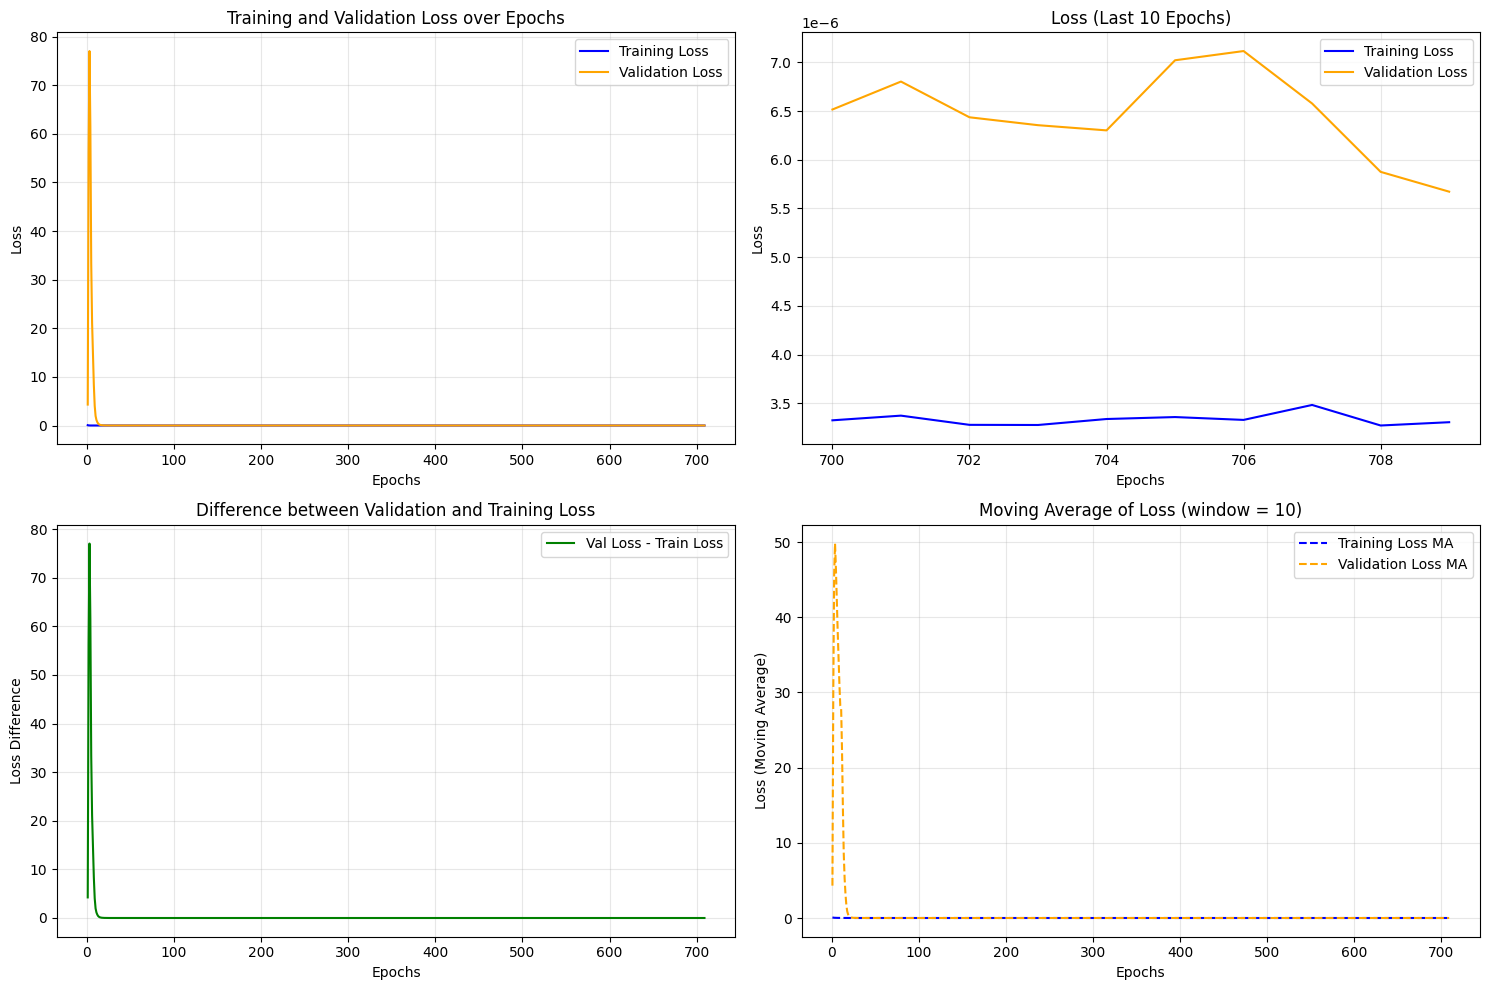

In [4]:
plot_loss(history)

# Prediction & Performance

In [5]:
# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/CMAQ_Emulator/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

In [6]:
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.3(hidden)/final_model(adjustedv2)')

pred_emis_data = []

# Load Test Data
dataset_2013 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/dataset_for_o3_v5.1.csv')
ctrl_data = pd.concat([dataset_2013], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
base_path_2013 = "/home/user/workdir/CMAQ_Emulator/main/datasets/concentration/2013"
conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2013, '1.00', f'ACONC.{i}'))
conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['O3'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
    
pred_emis_data = ctrl_data[:, :17*5]

_, X_emis_test, _, y_test = train_test_split(pred_emis_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test]) # 2가지 경계 조건에 따른 1년치 O3
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

2/2 [==============================] - 14s 4s/step


In [7]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (48, 82, 67)

pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


In [8]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=150, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    return y_err_mean, y_err_std

In [9]:
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


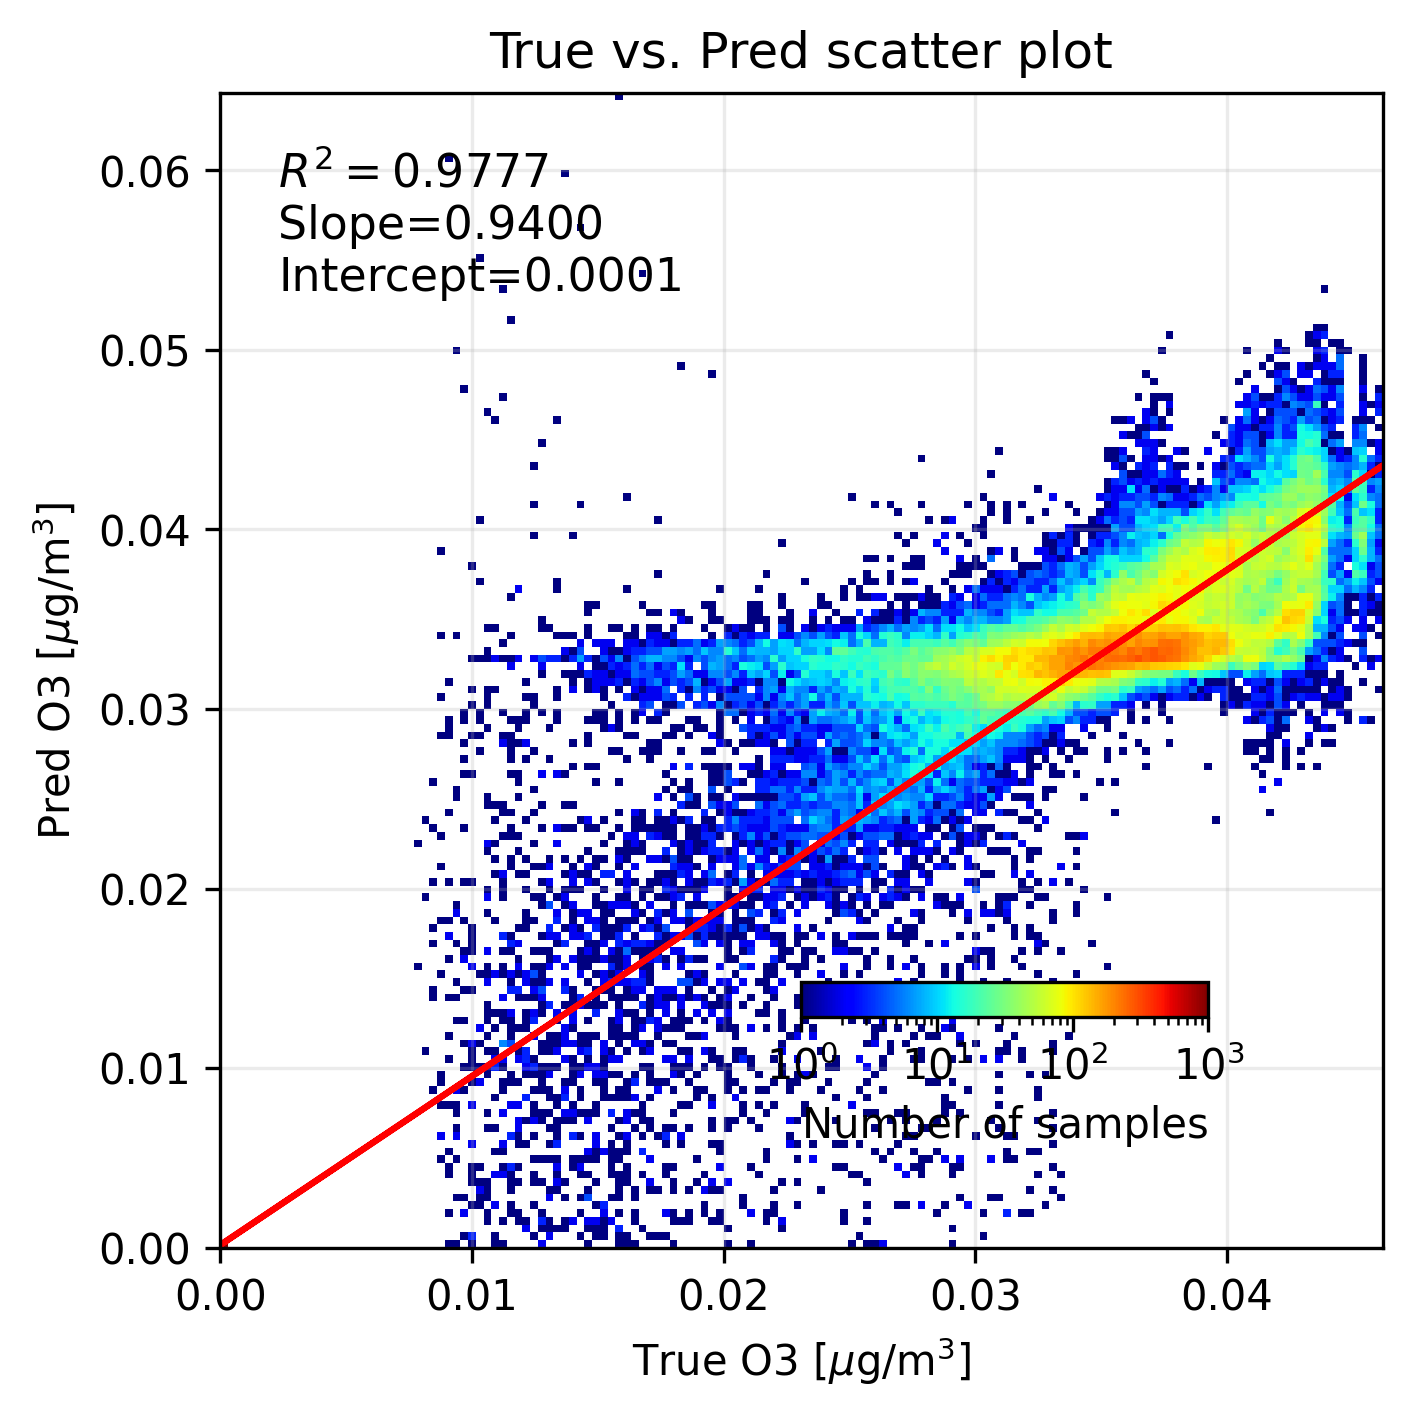

In [10]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True O3 [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred O3 [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

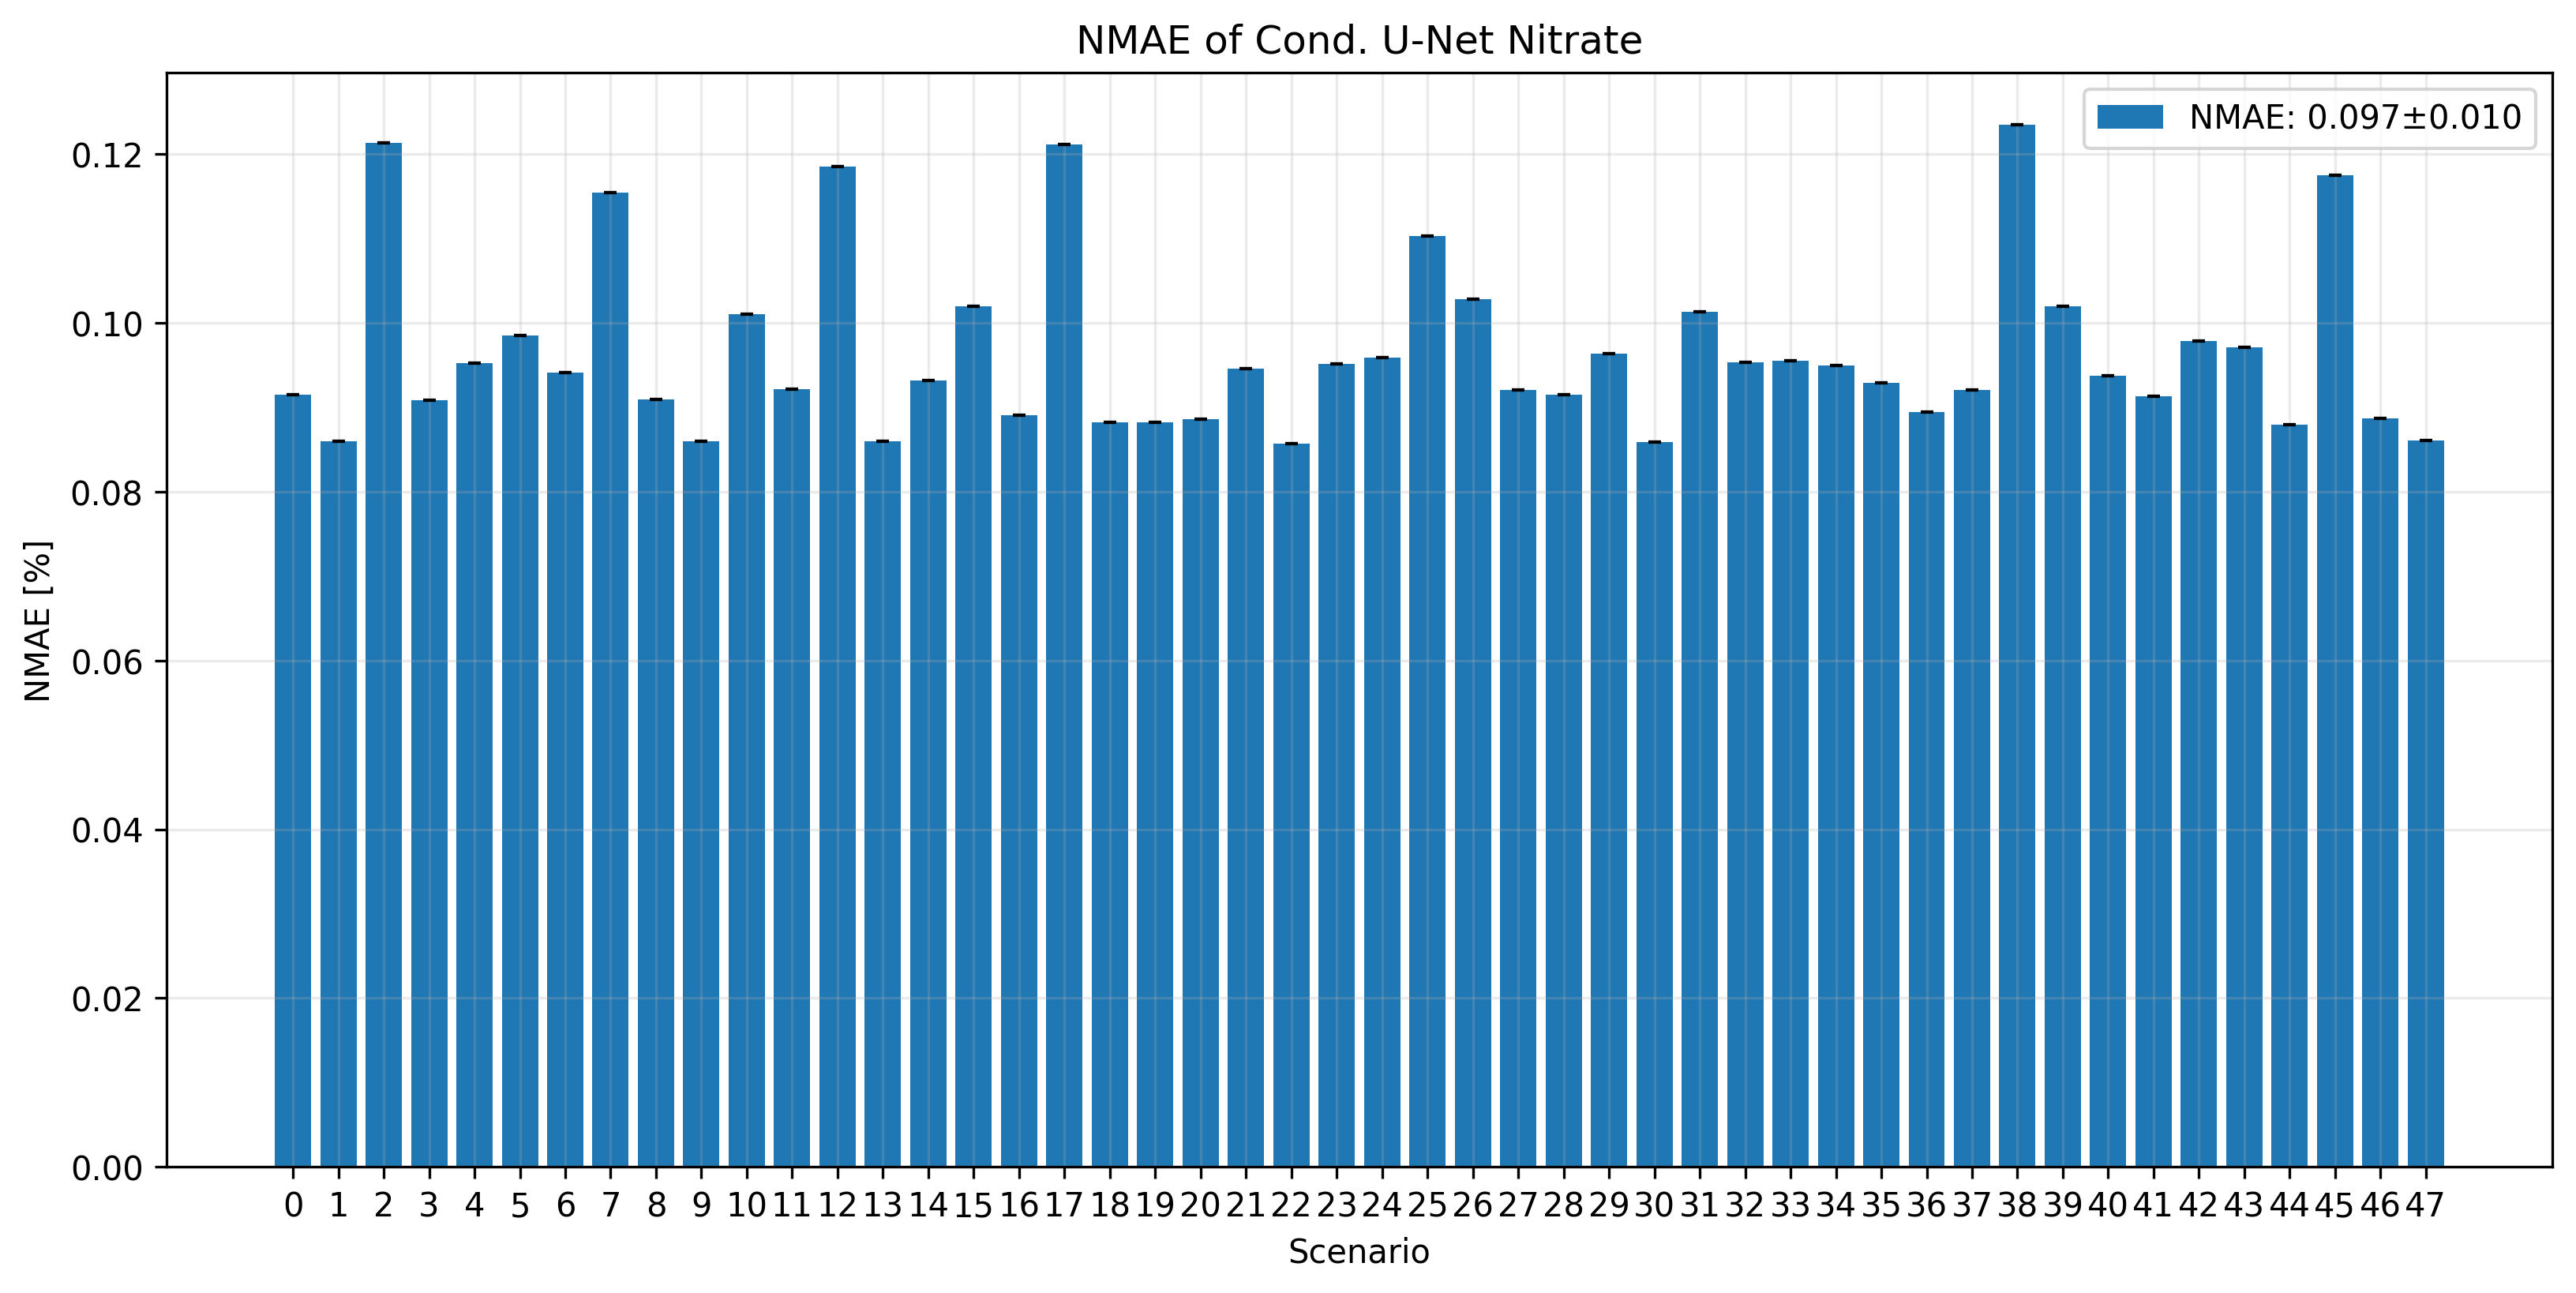

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
score, score_std = get_score(true_conc_map_w_lines, pred_conc_map_w_lines)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net Nitrate")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()

In [12]:
# np.set_printoptions(threshold=sys.maxsize)
# print(true_conc_map_w_lines[17])

22


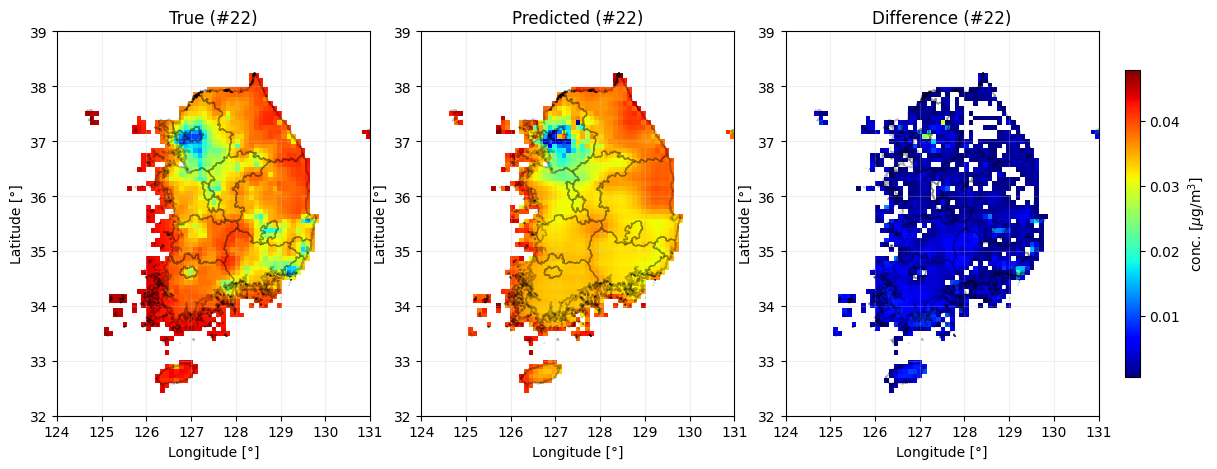

In [13]:
cmap_with_white = plt.get_cmap('jet').copy()   # 예: jet 컬러맵 복사
cmap_with_white.set_bad('white')               # 마스킹된 부분을 흰색으로

def plot_prediction_loss(y_true, y_pred, num_samples=1, indices=-1):
    if indices == -1 or indices < 0:
        indices = np.random.choice(len(y_true), num_samples, replace=False)
    else:
        index = indices
        indices = [index]
    
    # (예시) "선택된 인덱스들"만 고려한 local_min/local_max
    local_min = min(y_true[indices].min(), y_pred[indices].min())
    local_max = max(y_true[indices].max(), y_pred[indices].max())
    local_diff = np.abs(y_true[indices] - y_pred[indices])
    local_max = max(local_max, local_diff.max())

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = axes[np.newaxis, :]  # (1, 3) 형태로 맞춤

    # 지도 투영 좌표 범위
    x_min = -180000 + offset_x
    x_max =  414000 + offset_x
    y_min = -585000 + offset_y
    y_max =  144000 + offset_y

    x_ticks = np.linspace(x_min, x_max, 8)
    x_labels = [str(i) for i in range(124, 132)]
    y_ticks = np.linspace(y_min, y_max, 8)
    y_labels = [str(i) for i in range(32, 40)]

    # "0 이하이면 흰색"으로 표시하고 싶다면:
    threshold = 0.0005  # 또는 원하는 임계값(예: local_min 등)

    for i, idx in enumerate(indices):
        # (A) True 데이터
        data_true = y_true[idx][::-1]
        # 2) 마스킹: threshold 이하 부분을 마스크
        masked_true = np.ma.masked_where(data_true <= threshold, data_true)
        
        im_true = axes[i, 0].imshow(
            masked_true,
            cmap=cmap_with_white,          # 마스킹 컬러맵
            extent=(x_min, x_max, y_min, y_max),
            vmin=threshold,                # 컬러 스케일 최소
            vmax=local_max                 # 컬러 스케일 최대
        )
        ctprvn_proj.boundary.plot(
            ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25
        )
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_xlim(x_min, x_max)
        axes[i, 0].set_ylim(y_min, y_max)
        axes[i, 0].set_xticks(x_ticks)
        axes[i, 0].set_yticks(y_ticks)
        axes[i, 0].set_xticklabels(x_labels)
        axes[i, 0].set_yticklabels(y_labels)
        axes[i, 0].grid(alpha=0.25, color='silver')

        # (B) Predicted
        data_pred = y_pred[idx][::-1]
        masked_pred = np.ma.masked_where(data_pred <= threshold, data_pred)

        im_pred = axes[i, 1].imshow(
            masked_pred,
            cmap=cmap_with_white,
            extent=(x_min, x_max, y_min, y_max),
            vmin=threshold,
            vmax=local_max
        )
        ctprvn_proj.boundary.plot(
            ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25
        )
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_xlim(x_min, x_max)
        axes[i, 1].set_ylim(y_min, y_max)
        axes[i, 1].set_xticks(x_ticks)
        axes[i, 1].set_yticks(y_ticks)
        axes[i, 1].set_xticklabels(x_labels)
        axes[i, 1].set_yticklabels(y_labels)
        axes[i, 1].grid(alpha=0.25, color='silver')

        # (C) Difference
        data_diff = np.abs(y_true[idx] - y_pred[idx])[::-1]
        masked_diff = np.ma.masked_where(data_diff <= threshold, data_diff)

        im_diff = axes[i, 2].imshow(
            masked_diff,
            cmap=cmap_with_white,
            extent=(x_min, x_max, y_min, y_max),
            vmin=threshold,
            vmax=local_max
        )
        ctprvn_proj.boundary.plot(
            ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25
        )
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_xlim(x_min, x_max)
        axes[i, 2].set_ylim(y_min, y_max)
        axes[i, 2].set_xticks(x_ticks)
        axes[i, 2].set_yticks(y_ticks)
        axes[i, 2].set_xticklabels(x_labels)
        axes[i, 2].set_yticklabels(y_labels)
        axes[i, 2].grid(alpha=0.25, color='silver')

    # 서브플롯 간격/레이아웃 조정
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.tight_layout(rect=[0, 0, 0.88, 0.96])

    # (3) 단일 컬러바
    cbar = fig.colorbar(
        im_true,
        ax=axes.ravel().tolist(),
        orientation='vertical',
        fraction=0.03,
        pad=0.02,
        shrink=0.8
    )
    cbar.set_label('conc. [$\\mu \\mathrm{g}/\\mathrm{m}^3$]')

    plt.show()

# ==============================
print(np.argmin(score))
plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines, indices=np.argmin(score))

In [14]:
true_conc_map_w_lines_re = true_conc_map_w_lines
pred_conc_map_w_lines_re = pred_conc_map_w_lines

true_conc_map_w_lines_re = np.delete(true_conc_map_w_lines, 17, axis=0)
pred_conc_map_w_lines_re = np.delete(pred_conc_map_w_lines, 17, axis=0)

print(true_conc_map_w_lines_re.shape)
print(pred_conc_map_w_lines_re.shape)

(47, 82, 67)
(47, 82, 67)


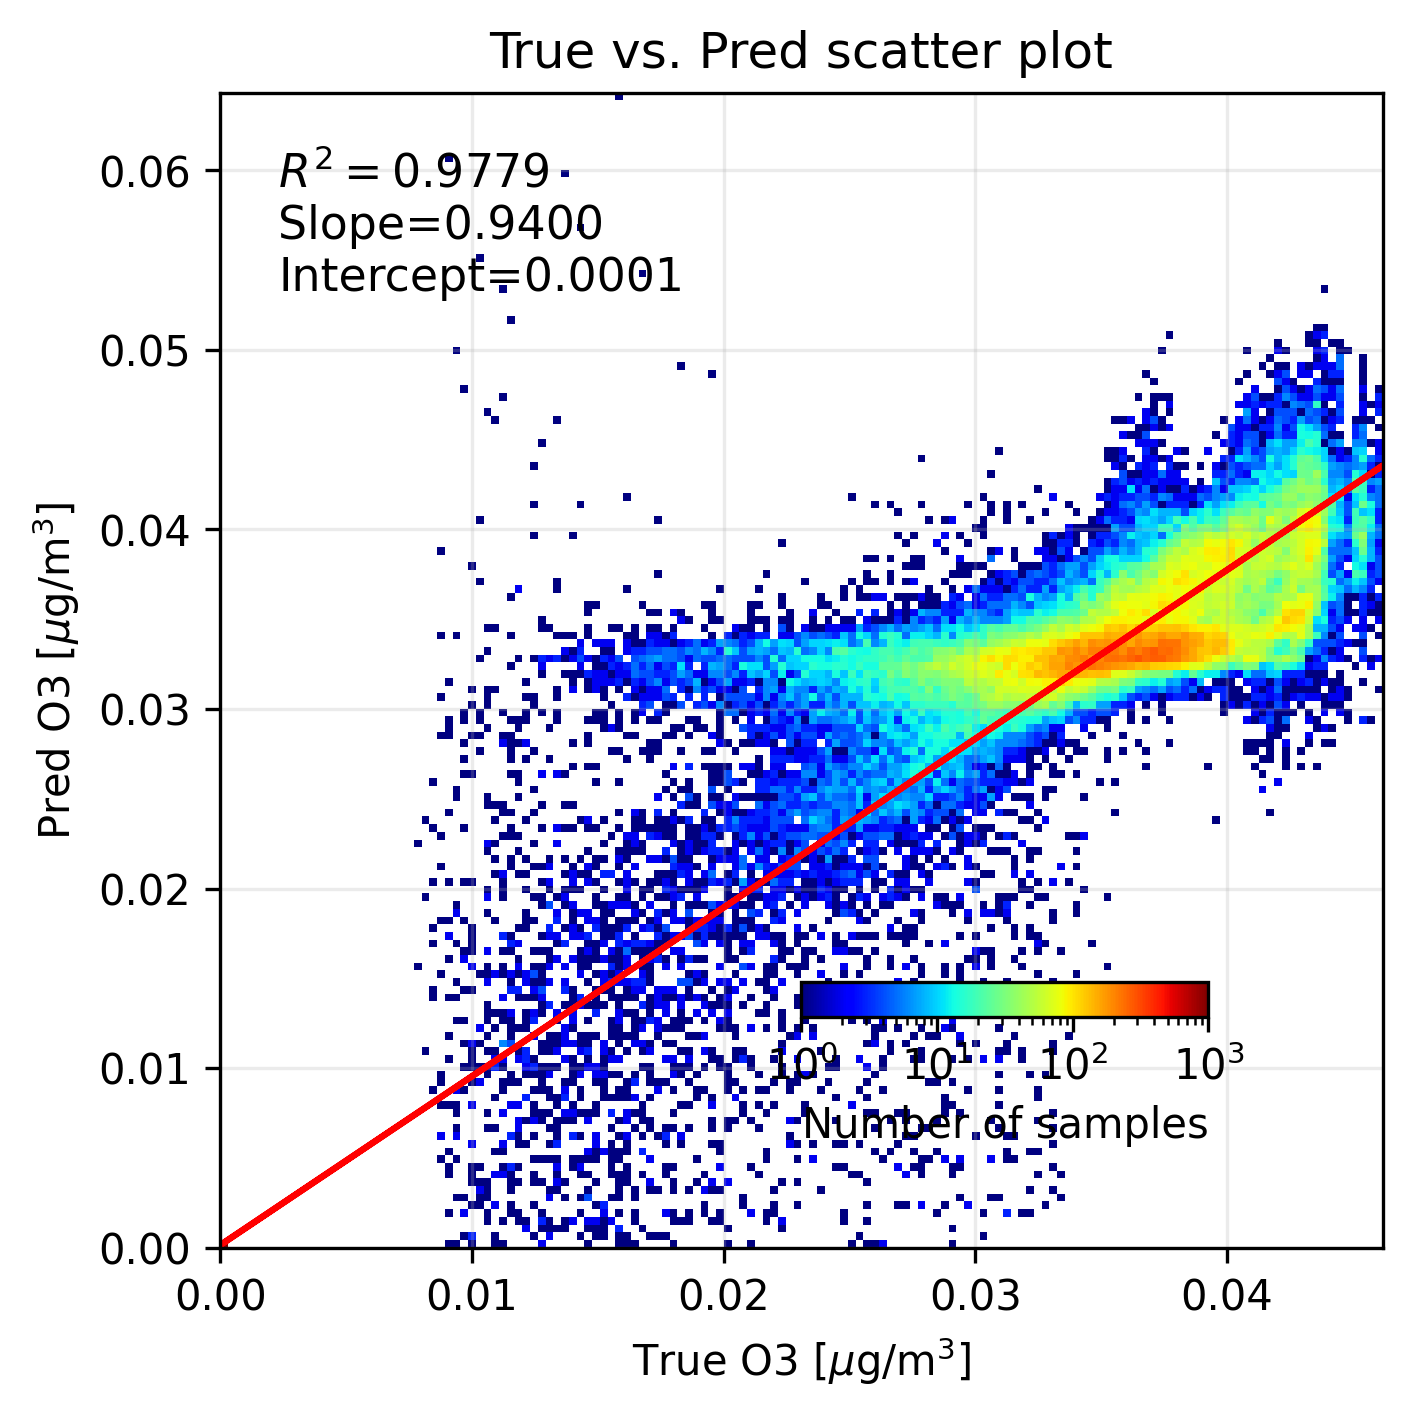

In [15]:
y_true_modi = true_conc_map_w_lines_re.reshape(-1)
y_pred_modi = pred_conc_map_w_lines_re.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True O3 [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred O3 [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

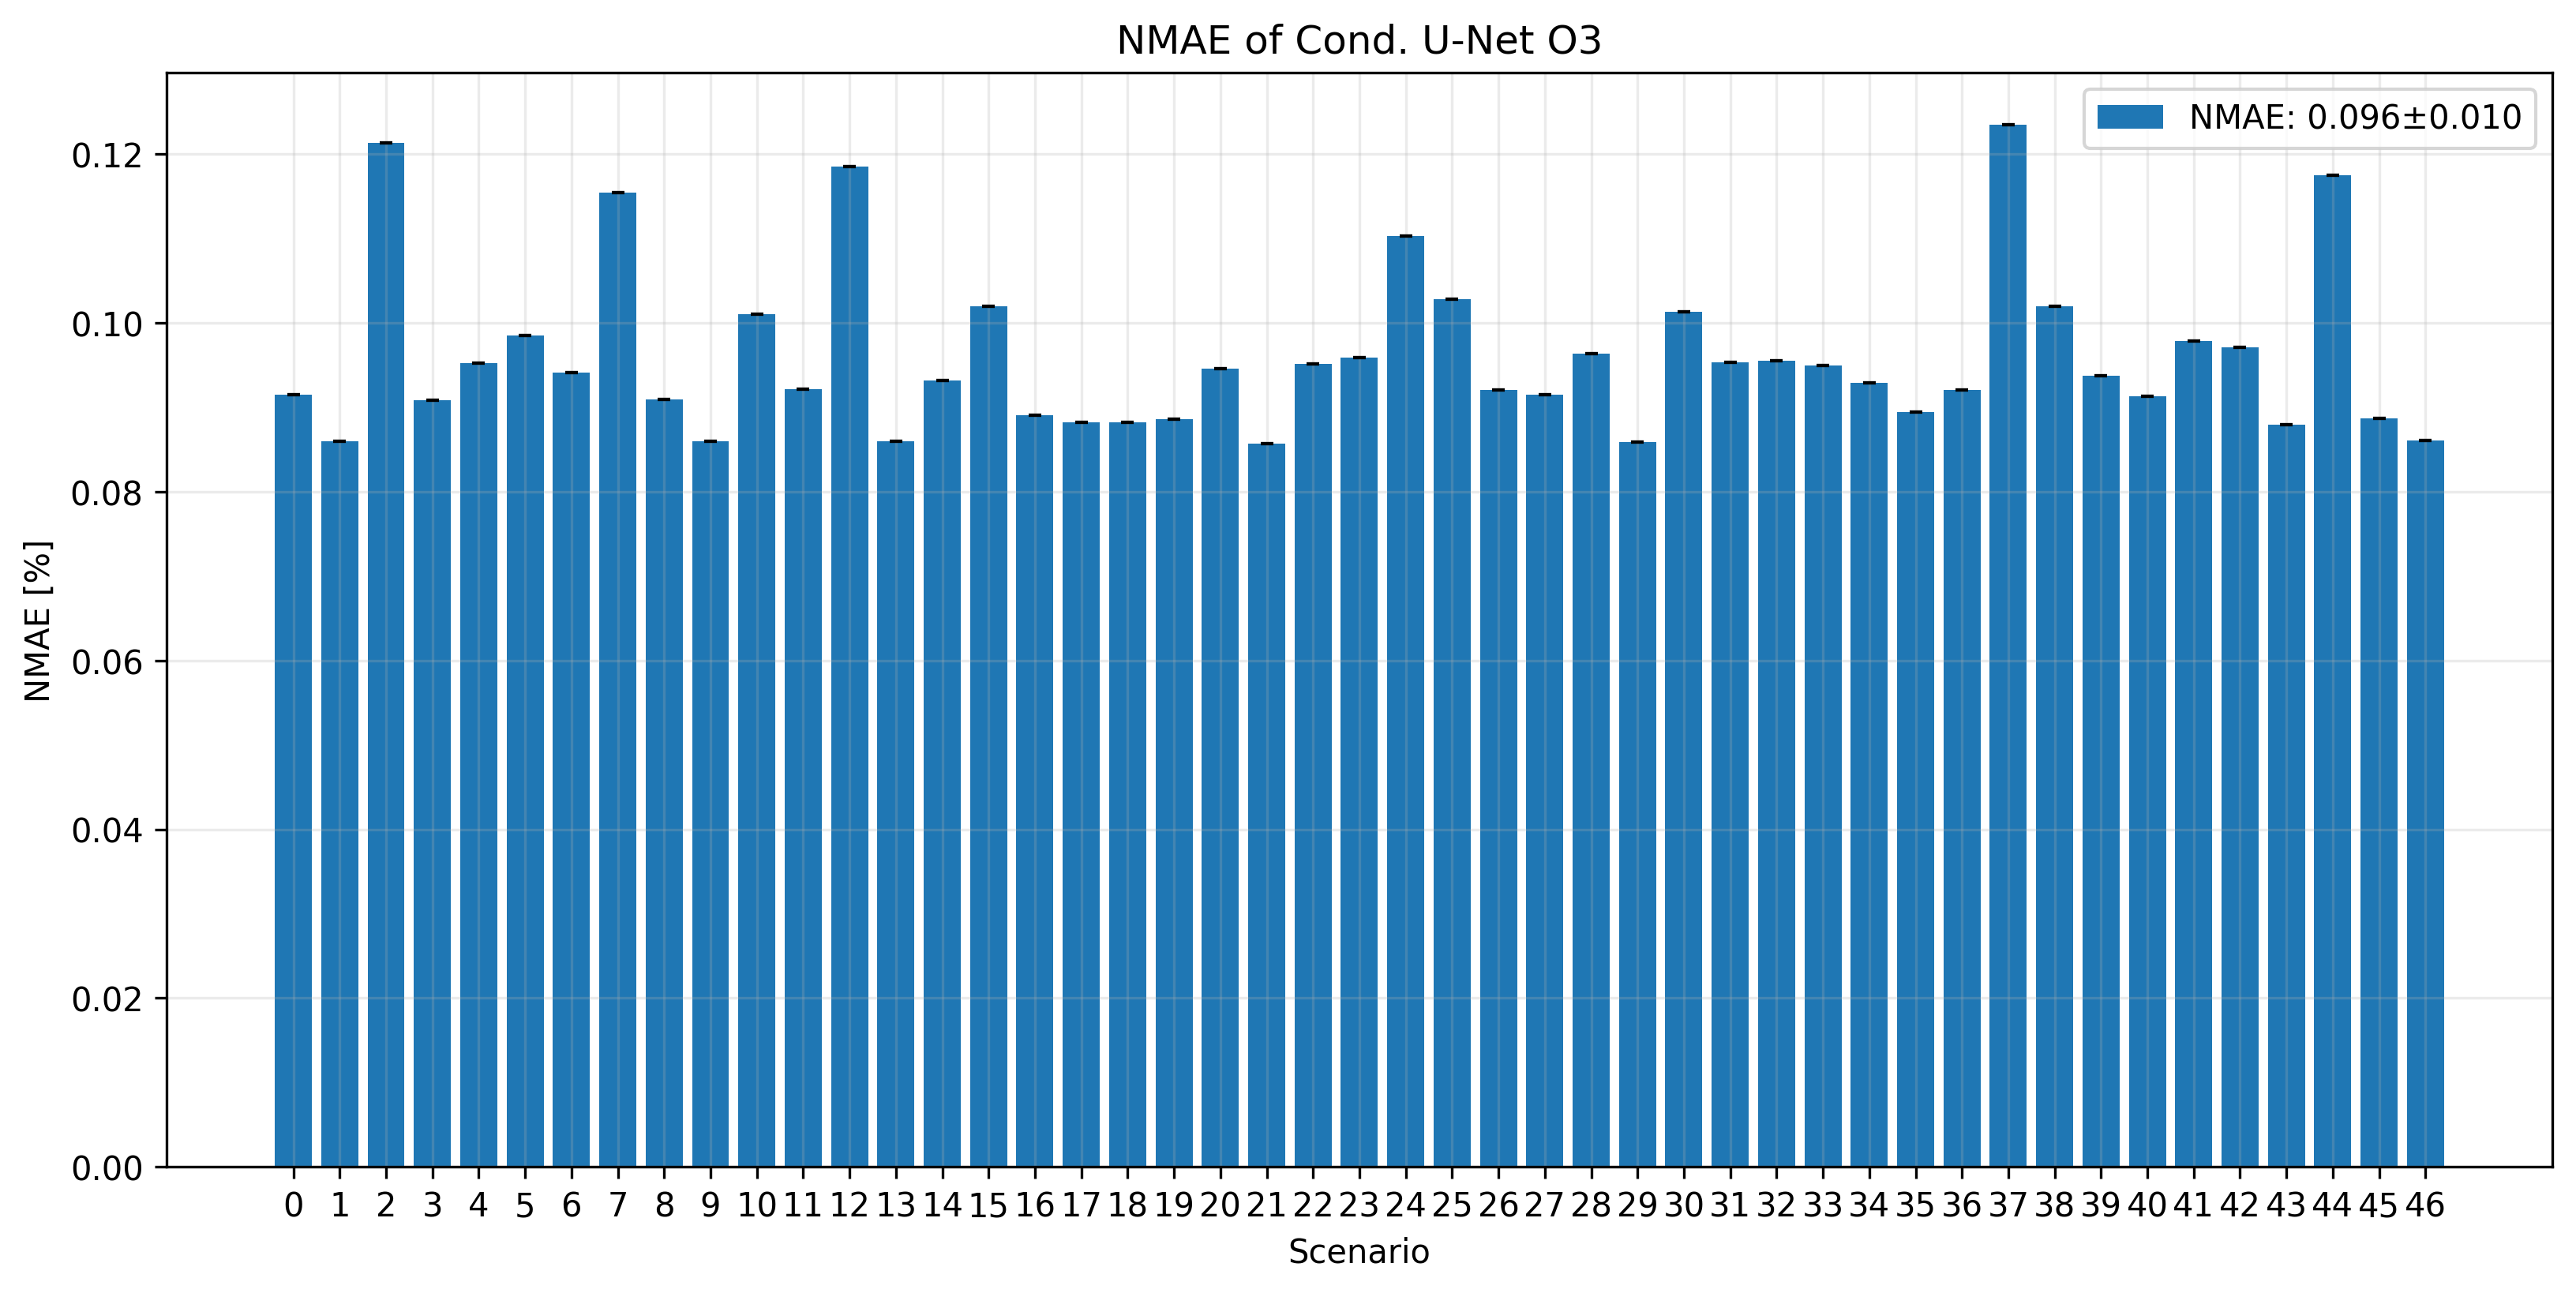

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
score, score_std = get_score(true_conc_map_w_lines_re, pred_conc_map_w_lines_re)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]-1), score, yerr=score_std, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]-1), range(y_test.shape[0]-1))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net O3")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()